In [2]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt 
# Here we will define the function for preprocessing and augmentation
def shadow_augmentation(image):
    # Let us randomly define the quadrilateral where we want to apply the shadow 
    pt1 = np.array([np.random.choice([0, image.shape[1]]), 0])
    pt2 = np.array([pt1[0], image.shape[0]])
    pt3 = np.array([np.random.randint(0, image.shape[0]//2), image.shape[0]])
    pt4 = np.array([np.random.randint(0, image.shape[0]//2), 0])
    pts = np.array([pt1, pt2, pt3, pt4])
    #print(pts)
    # Convert the image to Hue, Lightness, Saturation color model.
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Initialize the mask
    shadow_mask = 0*image_HLS[:, :, 1]
    # Now fill the quadrilateral as defined before
    shadow_mask = cv2.fillConvexPoly(shadow_mask, pts, 1)
    shadow_prob = np.random.random()
    # Apply shadow augmentation randomly to the images
    if shadow_prob > 0.5:
        random_shadow = 0.5
        image_HLS[:, :, 1][shadow_mask==1] = image_HLS[:, :, 1][shadow_mask==1]*random_shadow
    # Convert back to RGB Color model.
    image = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB)
    return image

def read_image(row, index, col_index):
        source_path = row[col_index][index]
        filename = source_path.split('/')[-1]
        current_path = './data/IMG/' + filename
        image = cv2.cvtColor(cv2.imread(current_path), cv2.COLOR_BGR2RGB)
        return image
    
def brightness_augment(image):
    # Convert to the HSV colorspace first.
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image = np.array(image, dtype = np.float64)
    # Randomly assign the brightness value 
    brightness_random = .5 + np.random.uniform()
    image[:,:,2] = image[:,:,2]*brightness_random
    image[:,:,2][image[:,:,2]>255]  = 255
    image = np.array(image, dtype = np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

def crop_image(image):
    cropped_image = image[50:135, :, :]
    return cropped_image 

def normalize_image(image):
    image.astype(np.float32)
    image = image/255. - 0.5 
    return image 

def resize_image(image, target_shape):
    return cv2.resize(image, target_shape)

def preprocess_image(image,target_shape):
    image = crop_image(image)
    image = resize_image(image, target_shape)
    image = normalize_image(image)
    return image 

def augmentation(row, index):
    col_index = 0
    cam_image = np.random.choice(['left', 'right', 'center'])
    #print(index)
    #print(row[3][index])
    steering = float(row[3][index])
    if cam_image == "left":
        steering += 0.25
        col_index = 1
    elif cam_image == "right":
        steering -= 0.25
        col_index = 2
    image = read_image(row, index, col_index)
    # Flipping Augmentation
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        image = cv2.flip(image, 1)
        steering = -1*steering
    # Brightness Augmentation
    image = brightness_augment(image)
    # Shadow Augmentation
    image = shadow_augmentation(image)
    # Preprocess the image 
    image = preprocess_image(image, (64, 64))
    return image, steering

In [ ]:
# from keras.layers import Dense, Flatten, Activation, Convolution2D, Cropping2D, Lambda, Dropout, Conv2D, ELU, MaxPooling2D
# from keras.models import Sequential
# def get_model():
#     model = Sequential()
#     # Convolution 1st layer
#     model.add(Convolution2D(filters = 32, kernel_size = (5, 5), strides = (2, 2), padding = "same", input_shape = (64, 64, 3)))
#     model.add(ELU())
#     model.add(MaxPooling2D((2, 2), padding = "valid"))
#     model.add(Dropout(0.5))
    
#     # 2nd layer
#     model.add(Convolution2D(filters = 64, kernel_size = (5, 5), strides = (2, 2), padding = "same", input_shape = (16, 16, 32)))
#     model.add(ELU())
#     model.add(MaxPooling2D((2, 2), padding = "valid"))
#     model.add(Dropout(0.5))
#     # 3rd layer
#     model.add(Convolution2D(filters = 128, kernel_size = (5, 5), strides = (2, 2), padding = "same", input_shape = (8, 8, 64)))
#     model.add(ELU())
#     model.add(MaxPooling2D((2, 2), padding = "valid"))
#     model.add(Dropout(0.5))
#     # 4th layer 
# #     model.add(Convolution2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "valid", input_shape = (8, 8, 48)))
# #     model.add(ELU())
# #     model.add(Dropout(0.5))
# #     # 5th layer
# #     model.add(Convolution2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "valid", input_shape = (6, 6, 64)))
# #     model.add(ELU())
# #     model.add(Dropout(0.5))
    
#     model.add(Flatten())
    
#     #model.add(Dense(1164))
#     #model.add(Dropout(0.5))
    
#     model.add(Dense(512))
#     #model.add(ELU())
#     #model.add(Dropout(0.5))
    
#     model.add(Dense(64))
#     #model.add(ELU())
#     #model.add(Dropout(0.5))
    
#     model.add(Dense(10))
#     #model.add(Dropout(0.5))
    
#     model.add(Dense(1))
    
#     model.summary()
#     model.compile(loss = "mse", optimizer = "adam", metrics = ["accuracy"])
#     return model 

In [21]:
from keras.layers import Dense, Flatten, Activation, Convolution2D, Cropping2D, Lambda, Dropout, Conv2D, ELU, MaxPooling2D
from keras.models import Sequential
from keras import optimizers
adam = optimizers.Adam(lr = 0.0001)
def get_model():
    model = Sequential()
    #Layer 1
    # Output of layer 1 is 64x64x3
    model.add(Convolution2D(filters = 3, kernel_size = (1, 1), strides = (1, 1), input_shape = (64, 64, 3), activation = "elu", padding = "same"))
    
    #Layer 2
    # Output of layer 2 is : 
    model.add(Convolution2D(filters = 32, kernel_size = (3,3), strides=(1,1), activation = 'elu', padding = "same"))
    model.add(Convolution2D(filters = 32, kernel_size = (3,3), strides=(1,1), activation = 'elu', padding = "same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    
    
    #Layer 3
    # Output of layer 3 is 
    model.add(Convolution2D(64, (3,3) ,strides=(1,1),activation='elu', padding = "same"))
    model.add(Convolution2D(64, (3,3) ,strides=(1,1),activation='elu', padding = "same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    #Layer 4
    # Output of layer 4 is 
    model.add(Convolution2D(128, (3,3) ,strides=(1,1),activation='elu', padding = "same"))
    model.add(Convolution2D(128, (3,3) ,strides=(1,1),activation='elu', padding = "same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    #Layer 6
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('elu'))

    #Layer 7
    model.add(Dense(64))
    model.add(Activation('elu'))

    #Layer 8
    model.add(Dense(16))
    model.add(Activation('elu'))

    #Layer 9
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mse',optimizer= "adam")
    return model


In [4]:
import csv
import sklearn
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

images = []
measurements = []
i = 0
def data_generator(row, batch_size = 32):
    N = len(row)
    batches_per_epoch = N // batch_size
    i = 0

    while(True):
        start = i*batch_size
        end = start + batch_size - 1
        # Initialize the batch data 
        X_train = np.zeros((batch_size, 64, 64, 3), dtype = np.float32)
        y_train = np.zeros((batch_size,), dtype = np.float32)
        for k in range(batch_size):
                index = np.random.randint(N)
                #print(N)
                keep_steering_angle = 0
                while keep_steering_angle == 0:
                    (x, y) = augmentation(row, index)
                    # If absolute value of steering angle smaller than 0.1, discard it with some probability.
                    if abs(y) < 0.1:
                        prob = np.random.uniform()
                        # Set steer_prob_threshold depending on how many steering angles close to zero, we want to discard.
                        if prob > steer_prob_threshold:
                            keep_steering_angle = 1
                    else:
                        # If absolute value of steering angle is greater than 0.1, then we keep it.
                        keep_steering_angle = 1
                #print(x)
                #plt.imshow(x, cmap = 'gray'), plt.show()
                
                (X_train[k], y_train[k]) = (x, y)
        i += 1 
        if i == batches_per_epoch - 1:
            i = 0 
        (X_train, y_train) = sklearn.utils.shuffle(X_train, y_train)
        yield (X_train, y_train)

In [22]:
# Let us read the data in a pandas dataframe object. And we require only the first 4 cols
import pandas as pd
from keras.callbacks import History, Callback
class LossHistory(Callback):
    def on_train_begin(self, logs = {}):
        self.training_loss = []
        self.training_acc = []
        self.validation_loss = []
        self.validation_acc = []
    def on_epoch_end(self, epoch, logs = {}):
        self.training_loss.append(logs.get('loss'))
        self.validation_loss.append(logs.get('val_loss'))
        self.training_acc.append(logs.get('acc'))
        self.validation_acc.append(logs.get('val_acc'))
        
history = LossHistory()
batch_size = 32
nb_epochs = 1
image_dataframe = pd.read_csv('C:/Users/lenovo/Documents/SDCND/Project-3/data/driving_log.csv', header=None, usecols = [0,1,2,3], skiprows = 1)
(nrows, ncols) = image_dataframe.shape
# Let us shuffle the rows of the dataframe before splitting into training and validation sets.
image_dataframe = image_dataframe.sample(frac = 1).reset_index(drop = "True")
# Let us take 80% of the data for training
num_training_lines = int(0.8*nrows)
training_lines = image_dataframe.loc[0:num_training_lines-1]
validation_lines = image_dataframe.loc[num_training_lines:]
steer_prob_threshold = 0.5
validation_lines = validation_lines.sample(frac=1).reset_index(drop = "True")
training_generator = data_generator(training_lines, batch_size)
validation_generator = data_generator(validation_lines, batch_size)
model = get_model()
steps_per_epoch = 20000 // batch_size
v_steps = 20000 // batch_size
model.fit_generator(training_generator, steps_per_epoch = steps_per_epoch, epochs = nb_epochs, verbose = 1, callbacks = [history], validation_data = validation_generator, validation_steps = v_steps)
model.save("Generator_Model.h5")
model.save_weights("Generator_Model_Weights.h5")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)        36928     
__________

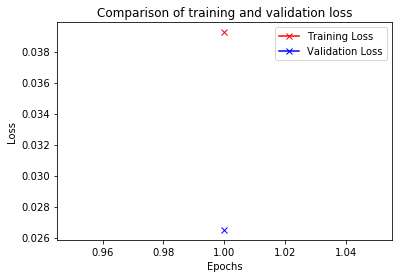

(<matplotlib.legend.Legend at 0x130ab94c588>, None)

In [20]:
# Plot the loss vs epochs.
plt.figure(1)
plt.title("Comparison of training and validation loss")
plt.plot(range(1, nb_epochs+1), history.training_loss, 'r-x', label = "Training Loss")
plt.plot(range(1, nb_epochs+1), history.validation_loss, 'b-x', label = "Validation Loss")
plt.ylabel("Loss"), plt.xlabel("Epochs")
plt.legend(loc = "upper right"), plt.show()


In [ ]:
import keras
print (keras.__version__)